In [1]:
import sys
from fcc_DRs import *
from fcc_utils import *

Using TensorFlow backend.


---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [3]:
P14Retina = RNA_counts.from_file('inputs/GSM1626795_P14Retina_3.digital_expression.txt.gz', cells_axis=1, labels=[0,0])

In [4]:
P14Retina.data.shape

(6120, 20169)

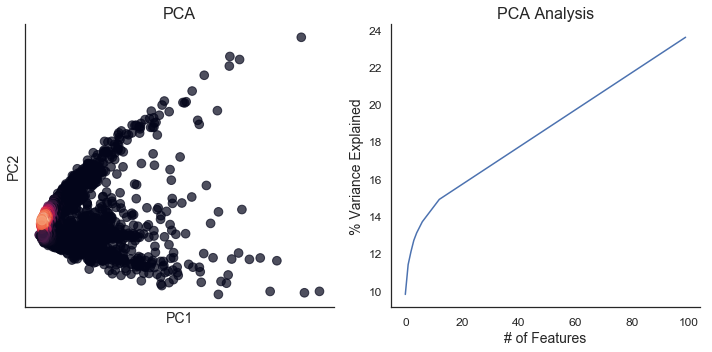

In [5]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(), n_components=100)
P14Retina_PCA100.plot()

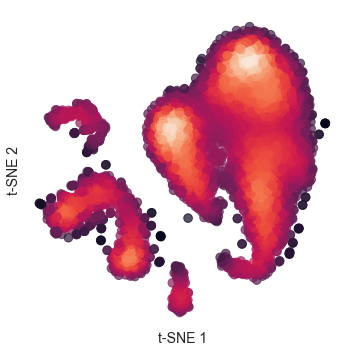

CPU times: user 48.3 s, sys: 1.78 s, total: 50.1 s
Wall time: 50 s


In [6]:
%%time 
P14Retina_tSNE = fcc_tSNE(P14Retina_PCA100.results, perplexity=30) # use standard perplexity of 30 here
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12e177438>)

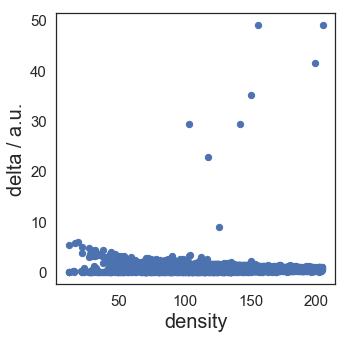

In [7]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12de31630>)

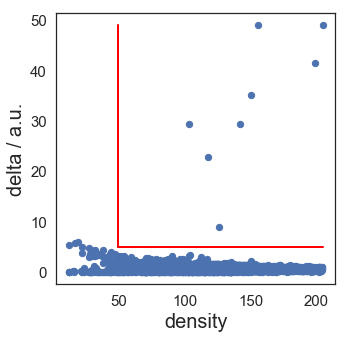

In [8]:
P14Retina_tSNE.clu.assign(50,5) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

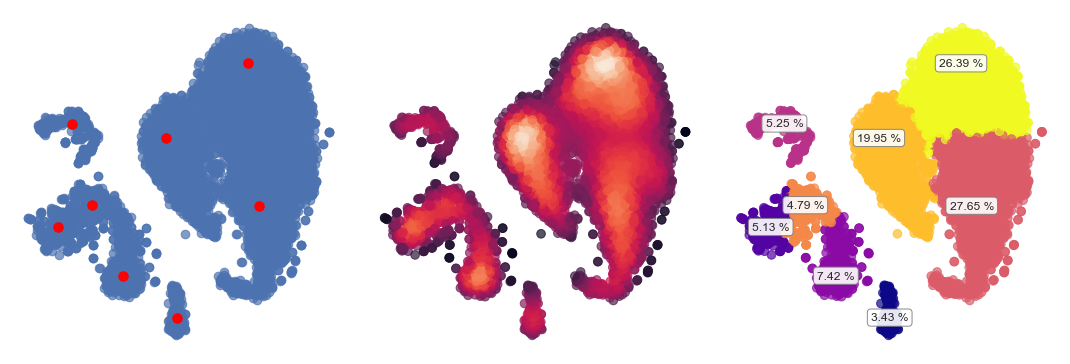

In [9]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [10]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score()))

Silhouette Score: 0.43498581647872925



---
#### 1. subsample discrete dataset and perform DRs
* select _500 most variable genes_
* downsample to _1000 cells_ with _proportional representation from prior clustering_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [23]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 


In [24]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)


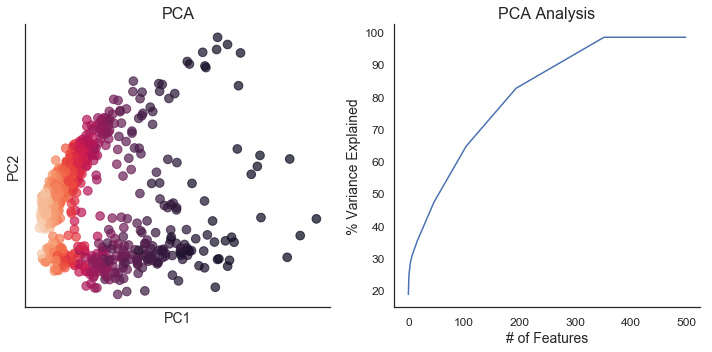

In [25]:
P14Retina_0_PCA500 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
P14Retina_0_PCA500.plot()

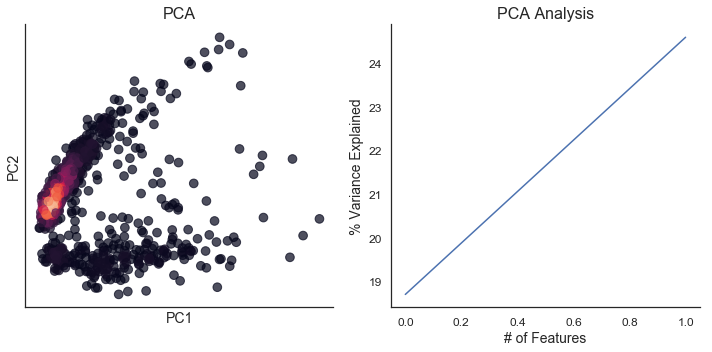

In [26]:
P14Retina_0_PCA2 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=2) # 2 component PCA
P14Retina_0_PCA2.plot()

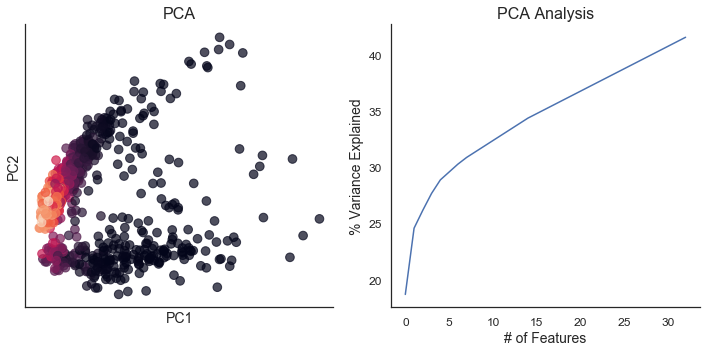

In [27]:
P14Retina_0_PCA33 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=33) # 33 component PCA
P14Retina_0_PCA33.plot()

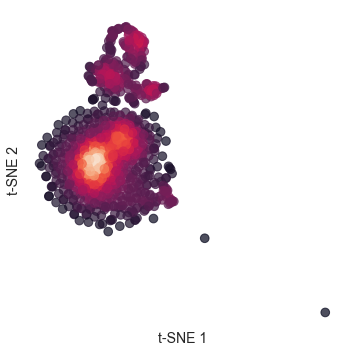

In [28]:
P14Retina_0_tSNE = fcc_tSNE(P14Retina_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_tSNE.plot()

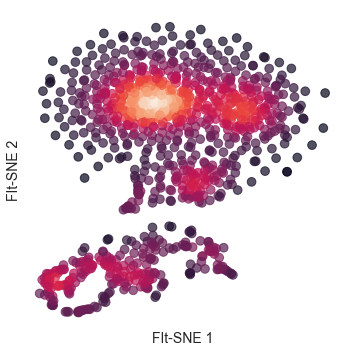

In [29]:
P14Retina_0_FItSNE = fcc_FItSNE(P14Retina_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_FItSNE.plot()

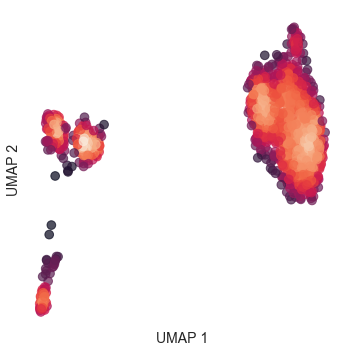

In [30]:
P14Retina_0_UMAP = fcc_UMAP(P14Retina_0.arcsinh_norm(), perplexity=30) # UMAP with perplexity 30
P14Retina_0_UMAP.plot()

In [31]:
P14Retina_0_DCA = fcc_DCA(P14Retina_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 500 genes and 1004 cells.
Calculating low dimensional representations...
Calculating reconstructions...


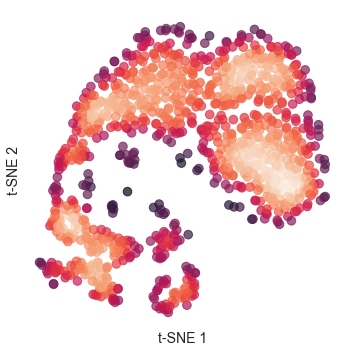

In [32]:
test = RNA_counts(data=P14Retina_0_DCA.results)
P14Retina_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_DCAtSNE.plot()

---
#### 2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

In [33]:
k = 30 # choose value for K-nearest neighbor calculations

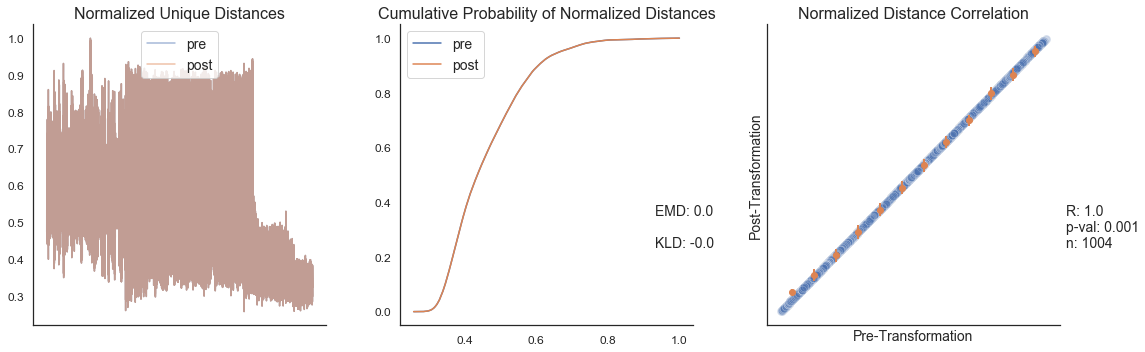

Knn Preservation: 100.0

CPU times: user 31.5 s, sys: 3.8 s, total: 35.3 s
Wall time: 34.8 s


In [34]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA500.knn_graph(k))))

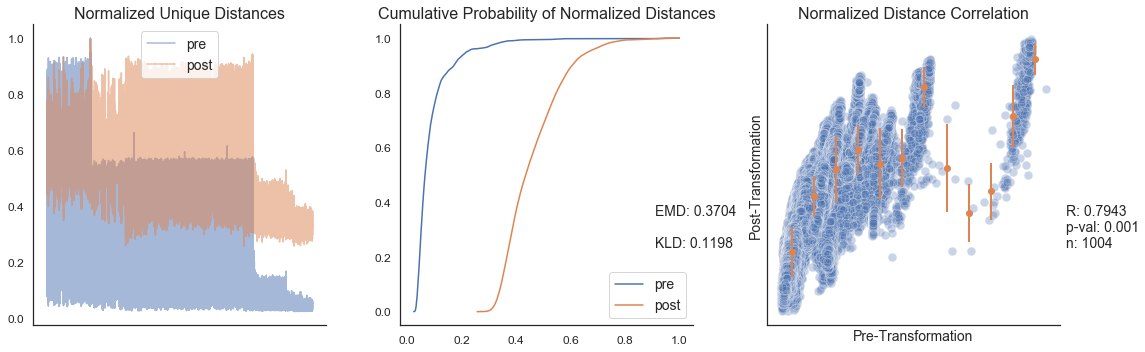

Knn Preservation: 95.3338

CPU times: user 31.3 s, sys: 4.33 s, total: 35.7 s
Wall time: 34.9 s


In [35]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000))))

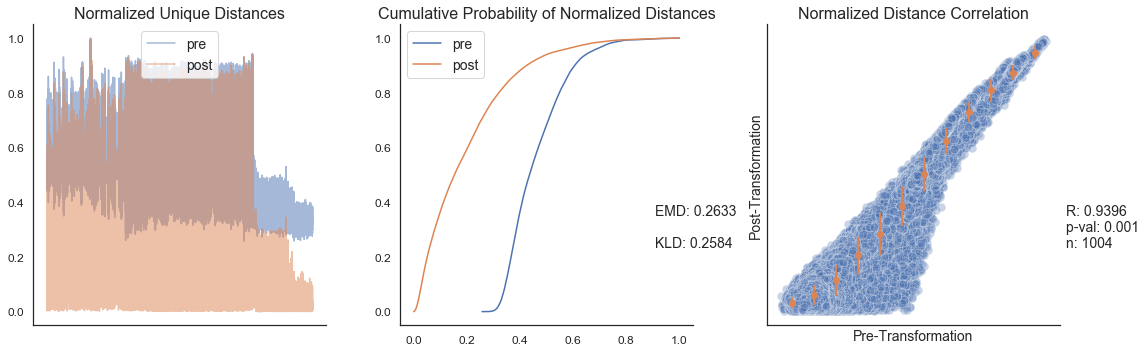

Knn Preservation: 96.812

CPU times: user 27.6 s, sys: 3.71 s, total: 31.3 s
Wall time: 30.6 s


In [36]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA2.knn_graph(k))))

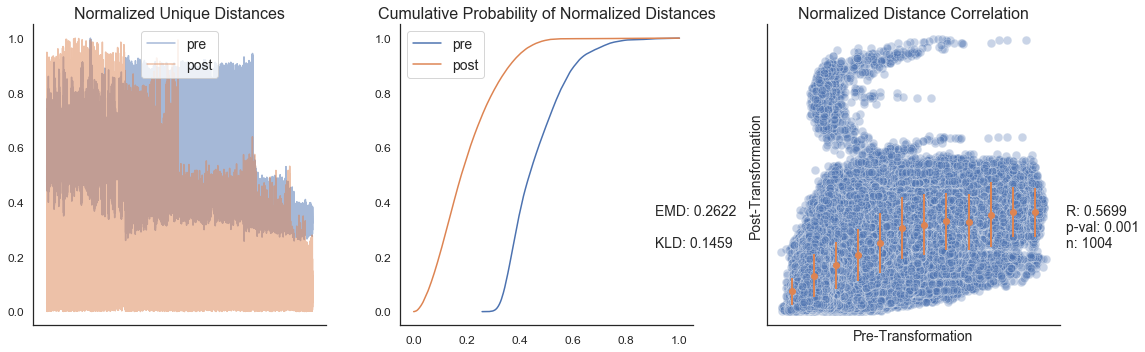

Knn Preservation: 95.1856

CPU times: user 27.4 s, sys: 3.15 s, total: 30.5 s
Wall time: 29.8 s


In [37]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_tSNE.knn_graph(k))))

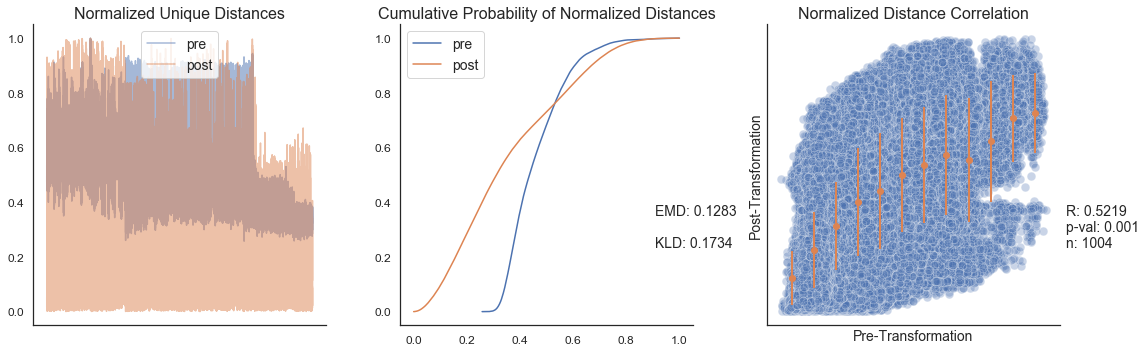

Knn Preservation: 95.4449

CPU times: user 27.4 s, sys: 3.29 s, total: 30.7 s
Wall time: 30 s


In [38]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_FItSNE.knn_graph(k))))

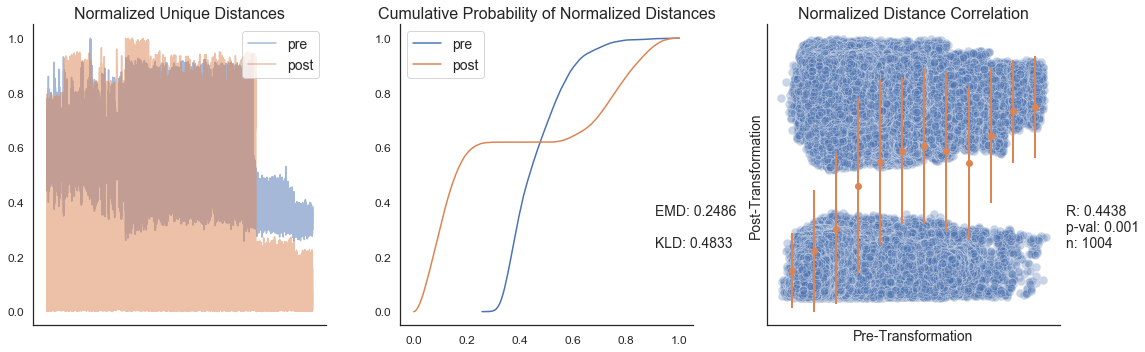

Knn Preservation: 94.7963

CPU times: user 28 s, sys: 3.81 s, total: 31.9 s
Wall time: 31.1 s


In [39]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_UMAP.knn_graph(k))))

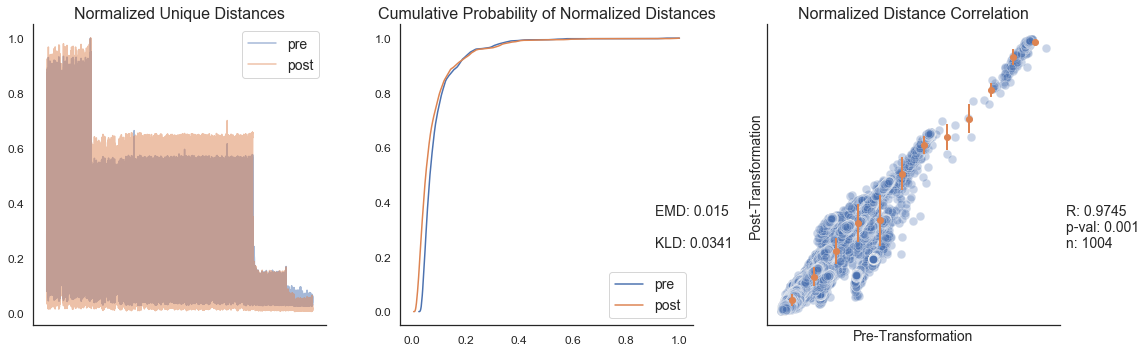

Knn Preservation: 96.6173

CPU times: user 28 s, sys: 3.88 s, total: 31.9 s
Wall time: 31.2 s


In [40]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0_DCA.knn_graph(k))))

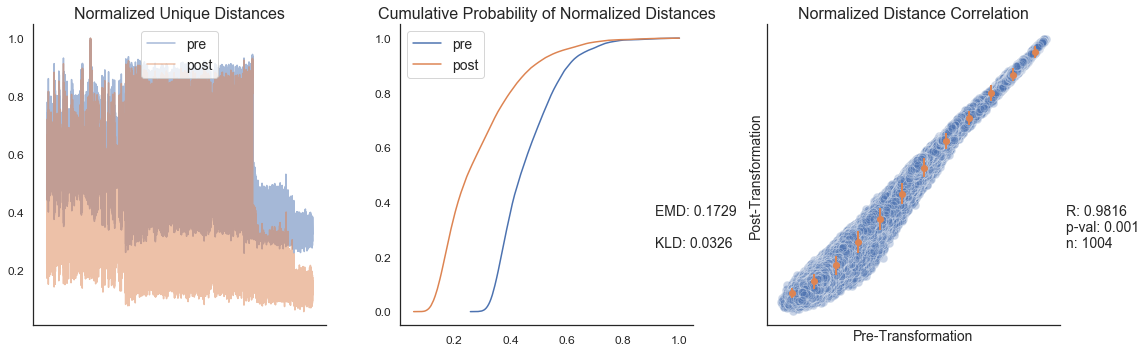

Knn Preservation: 97.5433

CPU times: user 28.7 s, sys: 4.05 s, total: 32.7 s
Wall time: 32 s


In [41]:
%%time
# look at 33-component PCA vs 500-feature dataset to compare to DCA
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA33.knn_graph(k))))

---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [42]:
P14Retina = RNA_counts.from_file('inputs/GSM1626797_P14Retina_5.digital_expression.txt.gz', cells_axis=1, labels=[0,0])

In [43]:
P14Retina.data.shape

(7650, 19719)

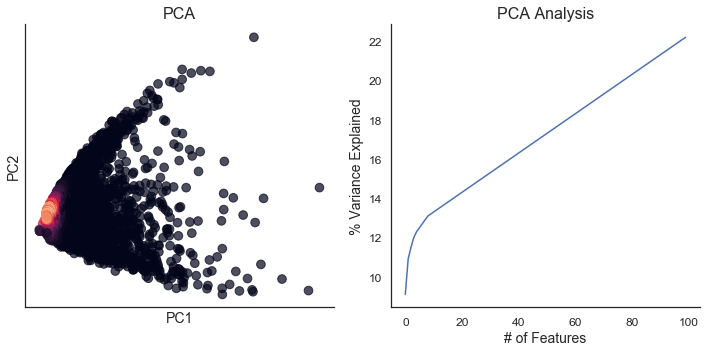

In [44]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(), n_components=100)
P14Retina_PCA100.plot()

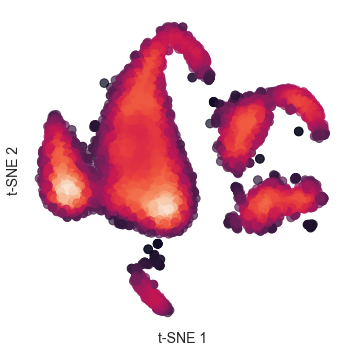

CPU times: user 1min 1s, sys: 2.3 s, total: 1min 3s
Wall time: 1min 3s


In [45]:
%%time 
P14Retina_tSNE = fcc_tSNE(P14Retina_PCA100.results, perplexity=30) # use standard perplexity of 30 here
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1252fc240>)

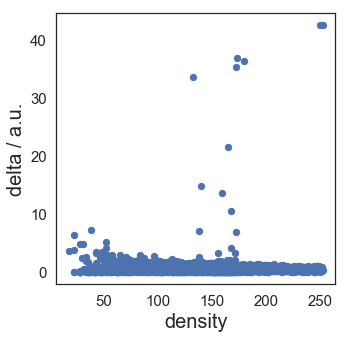

In [46]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12696f1d0>)

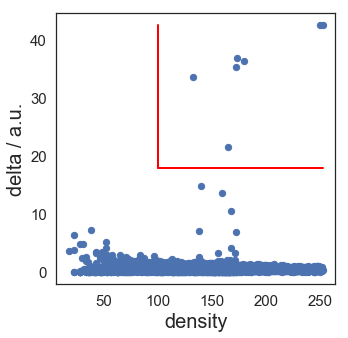

In [47]:
P14Retina_tSNE.clu.assign(100,18) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

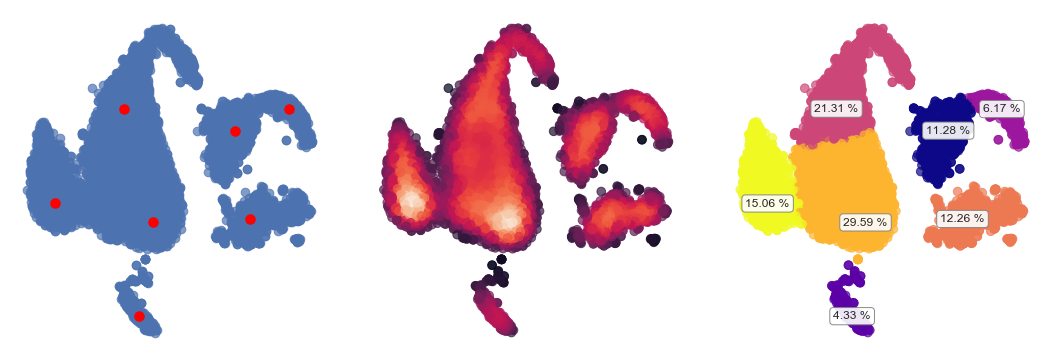

In [48]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [49]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score()))

Silhouette Score: 0.4904780387878418



---
#### 1. subsample discrete dataset and perform DRs
* select _500 most variable genes_
* downsample to _1000 cells_ with _proportional representation from prior clustering_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [50]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 

In [51]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)

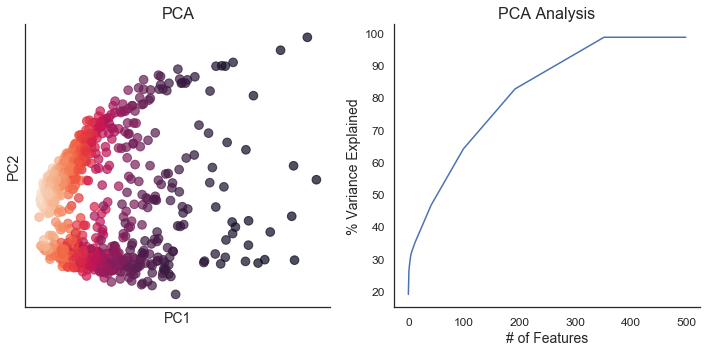

In [52]:
P14Retina_0_PCA500 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
P14Retina_0_PCA500.plot()

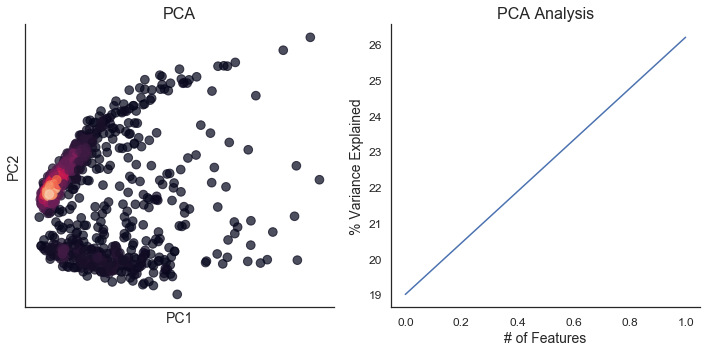

In [53]:
P14Retina_0_PCA2 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=2) # 2 component PCA
P14Retina_0_PCA2.plot()

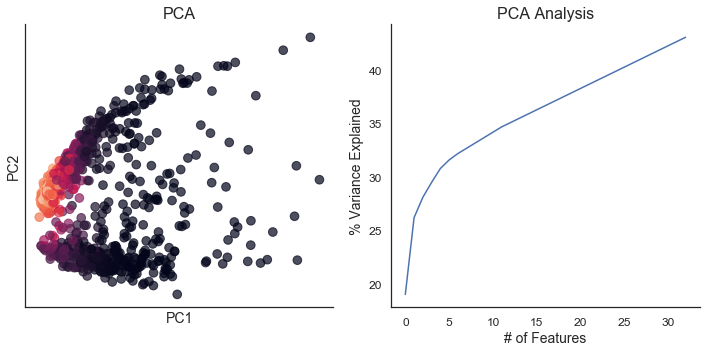

In [54]:
P14Retina_0_PCA33 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=33) # 33 component PCA
P14Retina_0_PCA33.plot()

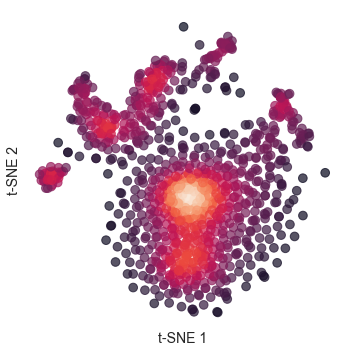

In [55]:
P14Retina_0_tSNE = fcc_tSNE(P14Retina_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_tSNE.plot()

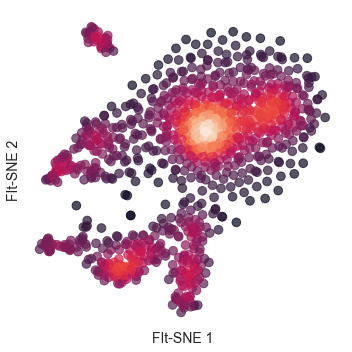

In [56]:
P14Retina_0_FItSNE = fcc_FItSNE(P14Retina_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_FItSNE.plot()

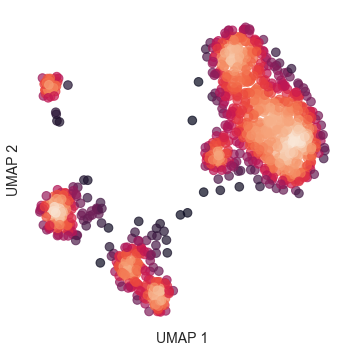

In [57]:
P14Retina_0_UMAP = fcc_UMAP(P14Retina_0.arcsinh_norm(), perplexity=30) # UMAP with perplexity 30
P14Retina_0_UMAP.plot()

In [58]:
P14Retina_0_DCA = fcc_DCA(P14Retina_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 500 genes and 1003 cells.
Calculating low dimensional representations...
Calculating reconstructions...


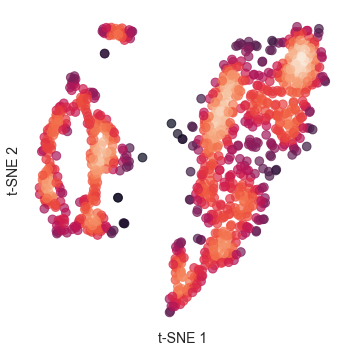

In [59]:
test = RNA_counts(data=P14Retina_0_DCA.results)
P14Retina_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_DCAtSNE.plot()

---
#### 2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

In [60]:
k = 30 # choose value for K-nearest neighbor calculations

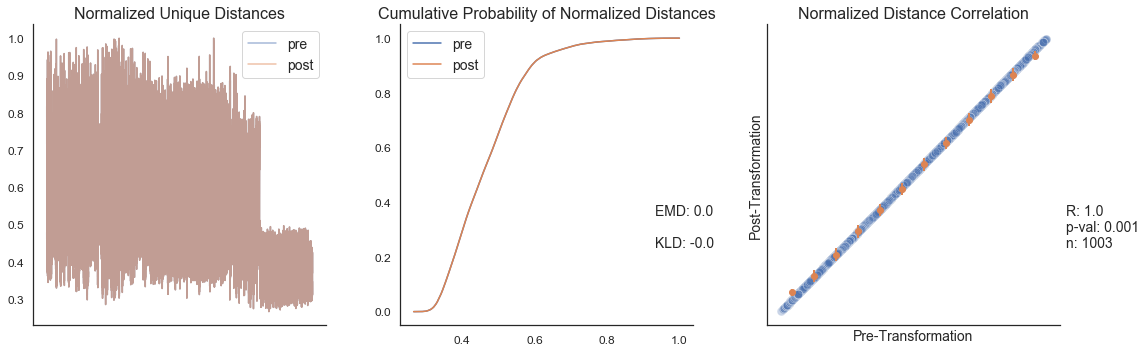

Knn Preservation: 100.0

CPU times: user 29.7 s, sys: 4.38 s, total: 34.1 s
Wall time: 33.4 s


In [61]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA500.knn_graph(k))))

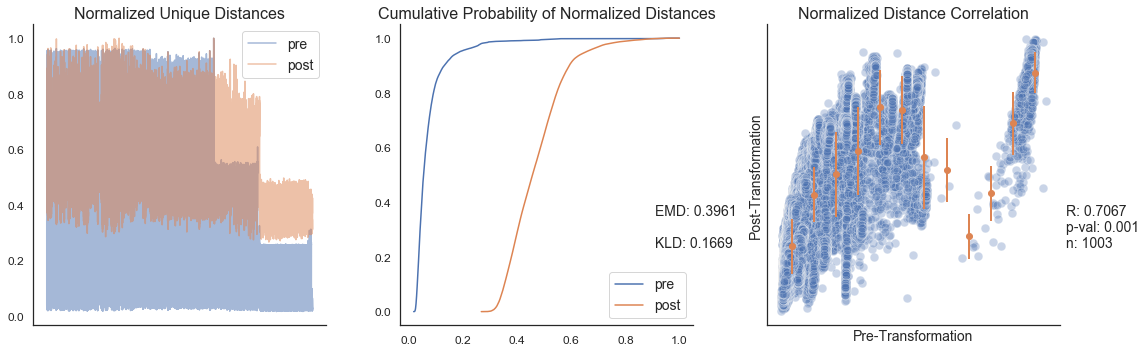

Knn Preservation: 95.506

CPU times: user 30.6 s, sys: 4.68 s, total: 35.3 s
Wall time: 34.7 s


In [62]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000))))

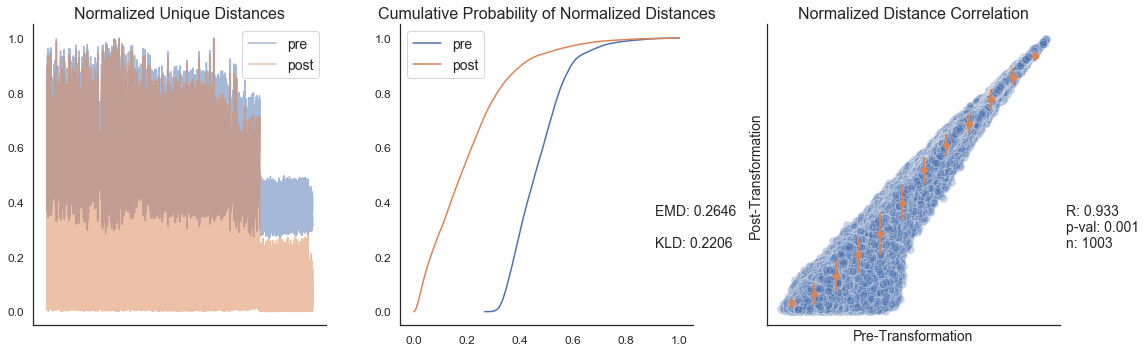

Knn Preservation: 97.0613

CPU times: user 26.6 s, sys: 3.66 s, total: 30.3 s
Wall time: 29.6 s


In [63]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA2.knn_graph(k))))

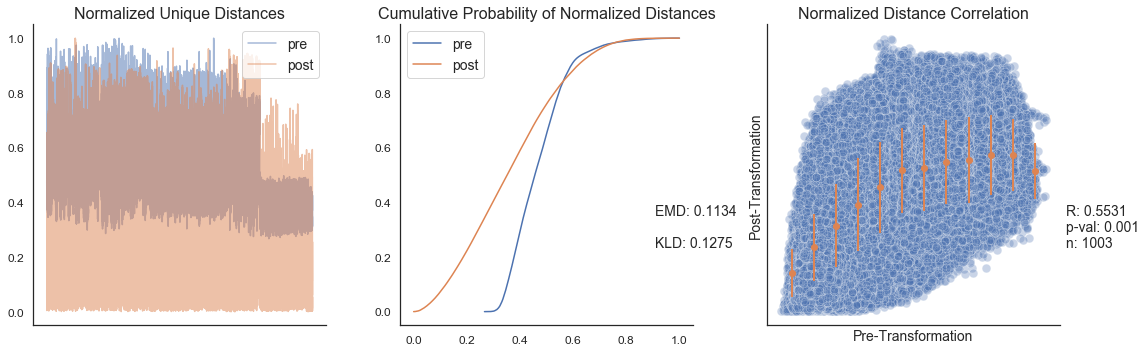

Knn Preservation: 95.3706

CPU times: user 27.7 s, sys: 2.78 s, total: 30.5 s
Wall time: 29.8 s


In [64]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_tSNE.knn_graph(k))))

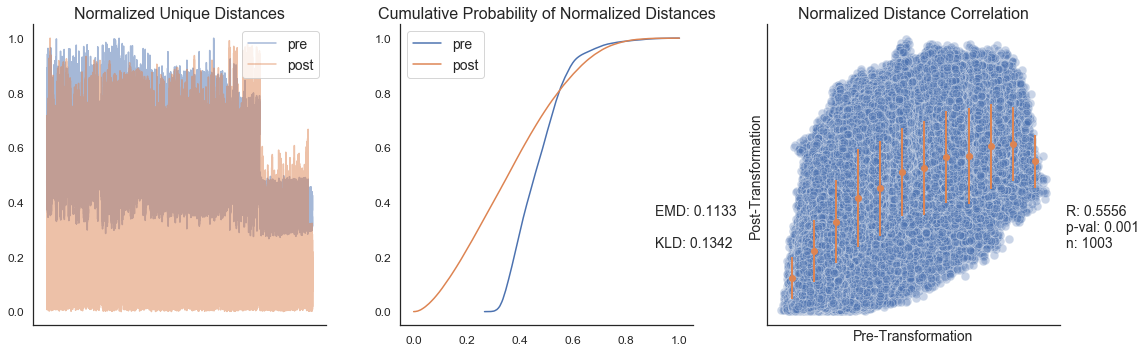

Knn Preservation: 95.5688

CPU times: user 27.5 s, sys: 2.47 s, total: 29.9 s
Wall time: 29.2 s


In [65]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_FItSNE.knn_graph(k))))

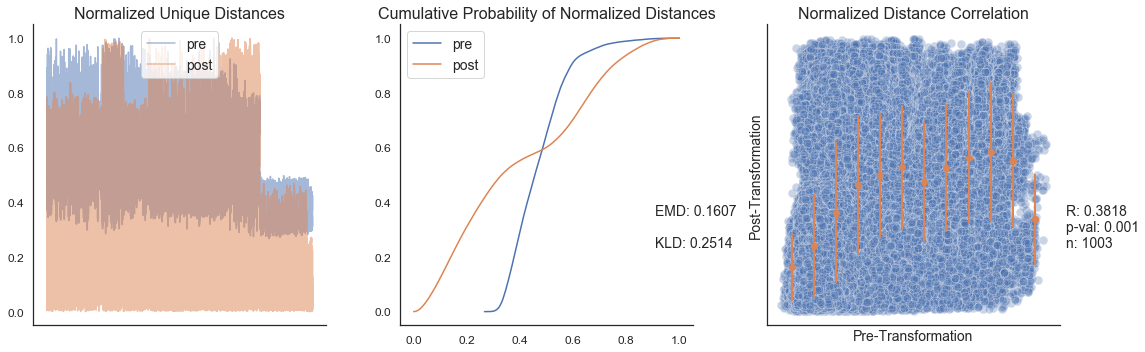

Knn Preservation: 94.8513

CPU times: user 27.3 s, sys: 2.62 s, total: 29.9 s
Wall time: 29.2 s


In [66]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_UMAP.knn_graph(k))))

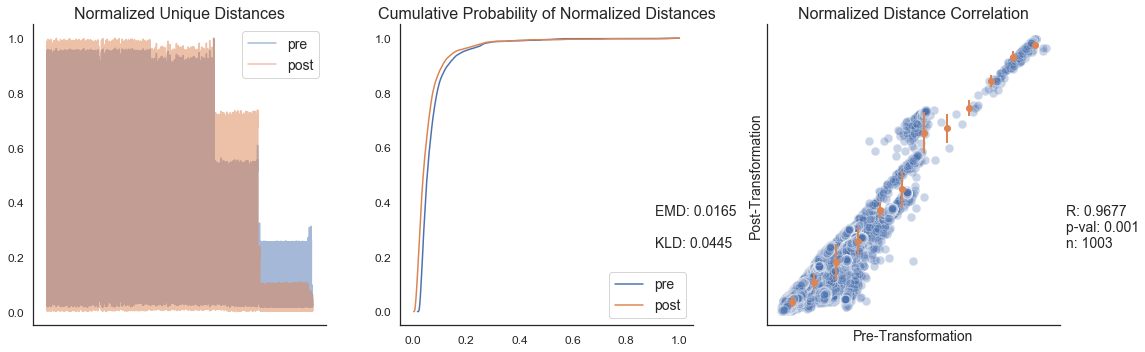

Knn Preservation: 96.4513

CPU times: user 28 s, sys: 3.52 s, total: 31.5 s
Wall time: 30.8 s


In [67]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0_DCA.knn_graph(k))))

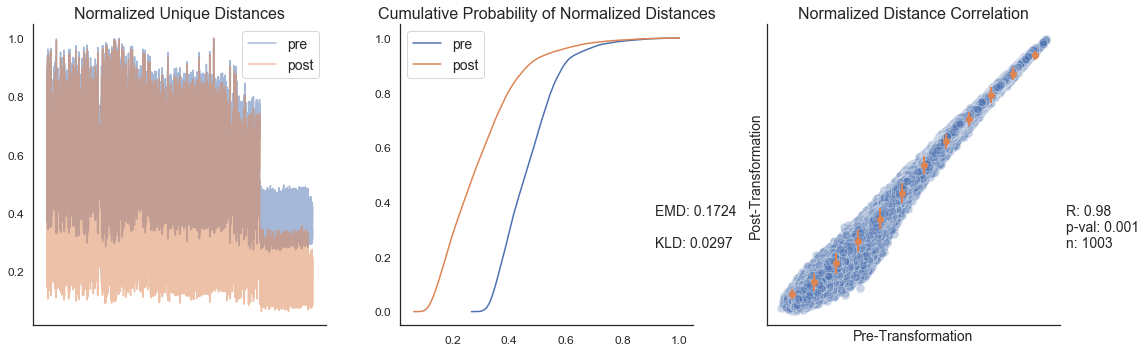

Knn Preservation: 97.7881

CPU times: user 27.3 s, sys: 3.93 s, total: 31.3 s
Wall time: 30.6 s


In [68]:
%%time
# look at 33-component PCA vs 500-feature dataset to compare to DCA
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA33.knn_graph(k))))

---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [69]:
P14Retina = RNA_counts.from_file('inputs/GSM1626799_P14Retina_7.digital_expression.txt.gz', cells_axis=1, labels=[0,0])

In [70]:
P14Retina.data.shape

(4000, 20105)

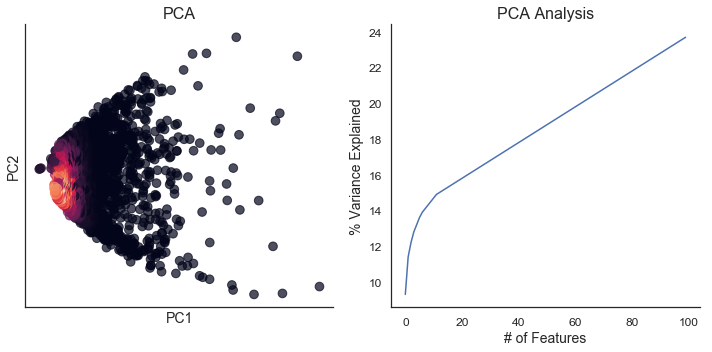

In [71]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(), n_components=100)
P14Retina_PCA100.plot()

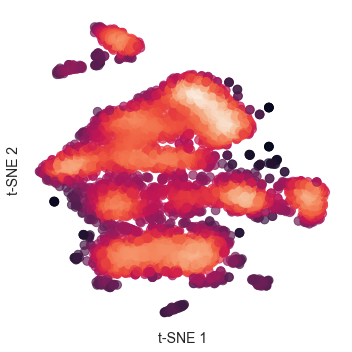

CPU times: user 34.2 s, sys: 1.27 s, total: 35.5 s
Wall time: 35.4 s


In [72]:
%%time 
P14Retina_tSNE = fcc_tSNE(P14Retina_PCA100.results, perplexity=30) # use standard perplexity of 30 here
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12b262160>)

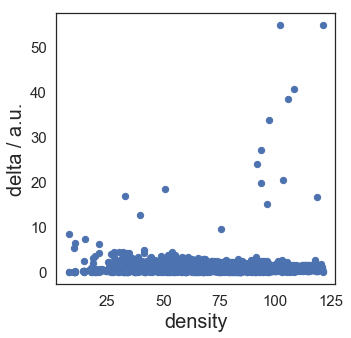

In [73]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12cbf3898>)

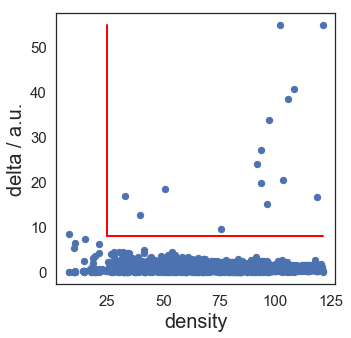

In [74]:
P14Retina_tSNE.clu.assign(25,8) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

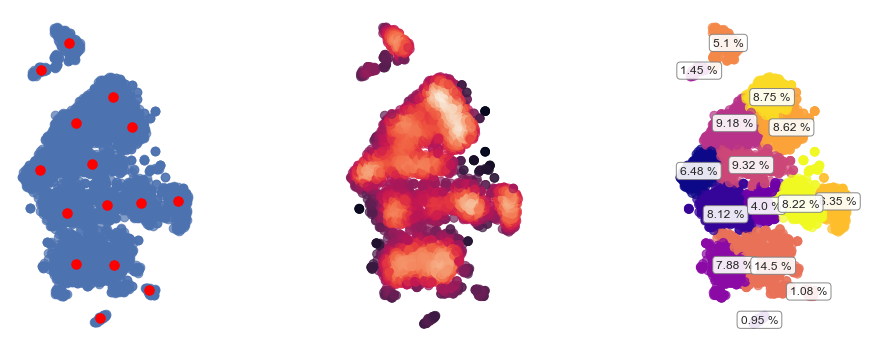

In [75]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [76]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score()))

Silhouette Score: 0.40335971117019653



---
#### 1. subsample discrete dataset and perform DRs
* select _500 most variable genes_
* downsample to _1000 cells_ with _proportional representation from prior clustering_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [77]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 

In [78]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)

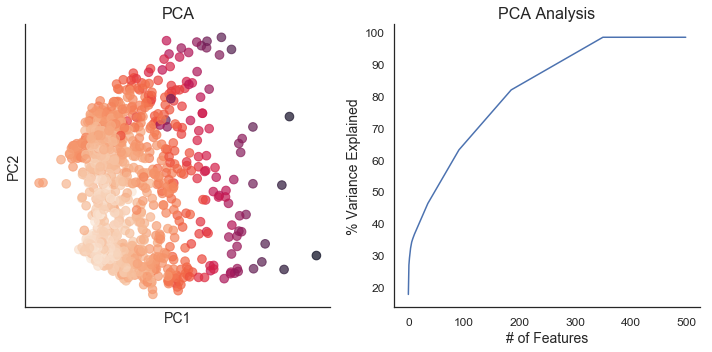

In [79]:
P14Retina_0_PCA500 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
P14Retina_0_PCA500.plot()

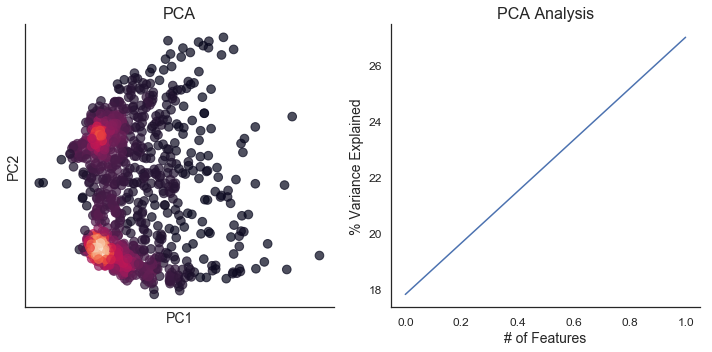

In [80]:
P14Retina_0_PCA2 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=2) # 2 component PCA
P14Retina_0_PCA2.plot()

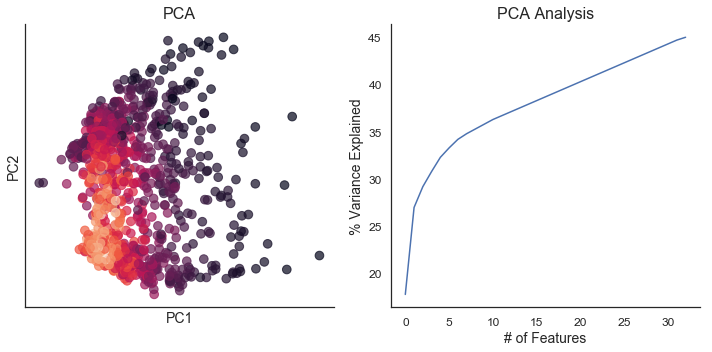

In [81]:
P14Retina_0_PCA33 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=33) # 33 component PCA
P14Retina_0_PCA33.plot()

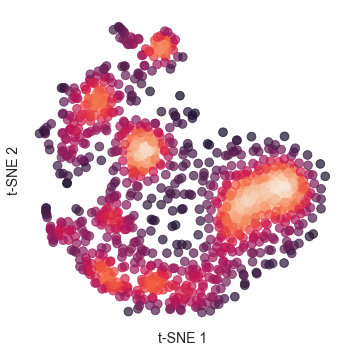

In [82]:
P14Retina_0_tSNE = fcc_tSNE(P14Retina_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_tSNE.plot()

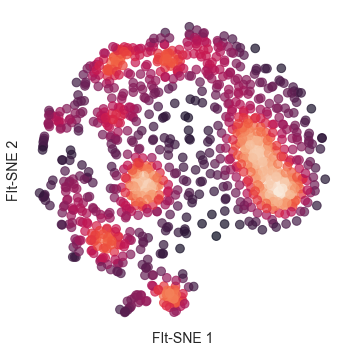

In [83]:
P14Retina_0_FItSNE = fcc_FItSNE(P14Retina_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_FItSNE.plot()

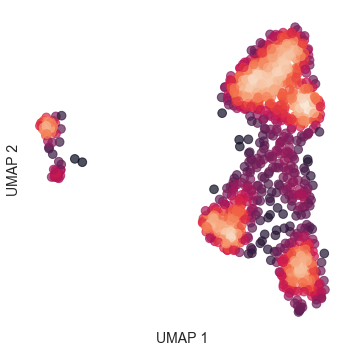

In [84]:
P14Retina_0_UMAP = fcc_UMAP(P14Retina_0.arcsinh_norm(), perplexity=30) # UMAP with perplexity 30
P14Retina_0_UMAP.plot()

In [85]:
P14Retina_0_DCA = fcc_DCA(P14Retina_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 500 genes and 1009 cells.
Calculating low dimensional representations...
Calculating reconstructions...


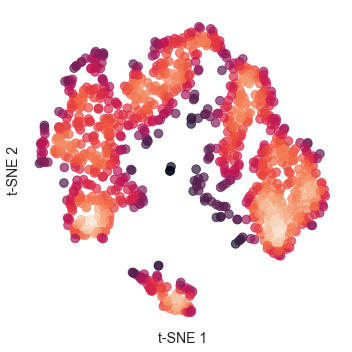

In [86]:
test = RNA_counts(data=P14Retina_0_DCA.results)
P14Retina_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_DCAtSNE.plot()

---
#### 2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

In [87]:
k = 30 # choose value for K-nearest neighbor calculations

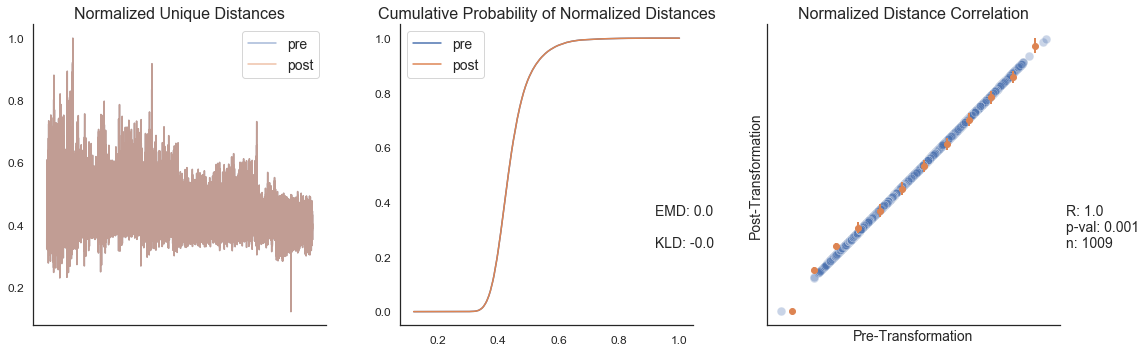

Knn Preservation: 100.0

CPU times: user 30.2 s, sys: 4.62 s, total: 34.8 s
Wall time: 34.3 s


In [88]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA500.knn_graph(k))))

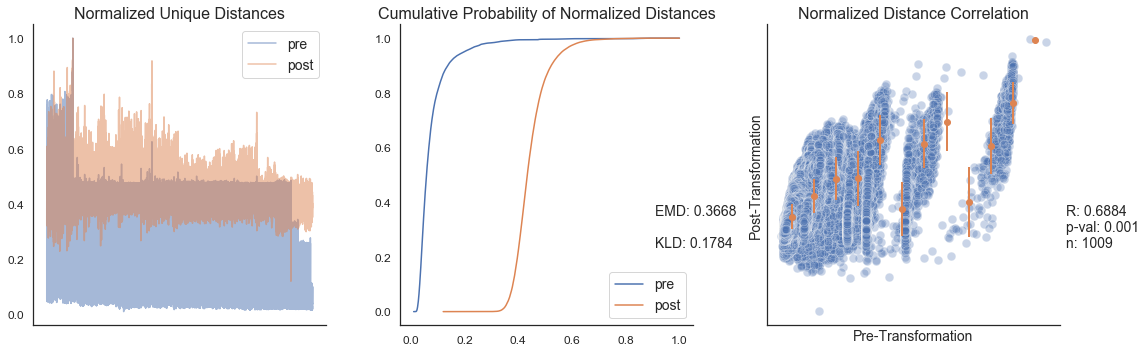

Knn Preservation: 95.7163

CPU times: user 29.7 s, sys: 4.31 s, total: 34 s
Wall time: 33.3 s


In [89]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000))))

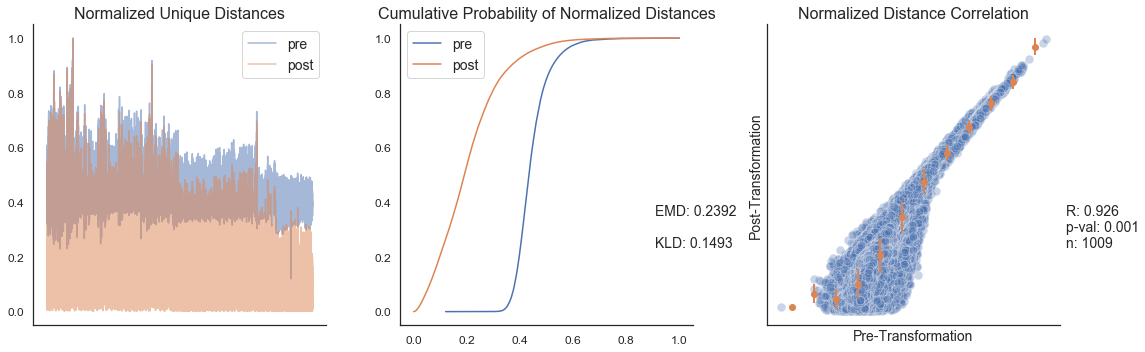

Knn Preservation: 97.7238

CPU times: user 26.4 s, sys: 4.49 s, total: 30.9 s
Wall time: 30.2 s


In [90]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA2.knn_graph(k))))

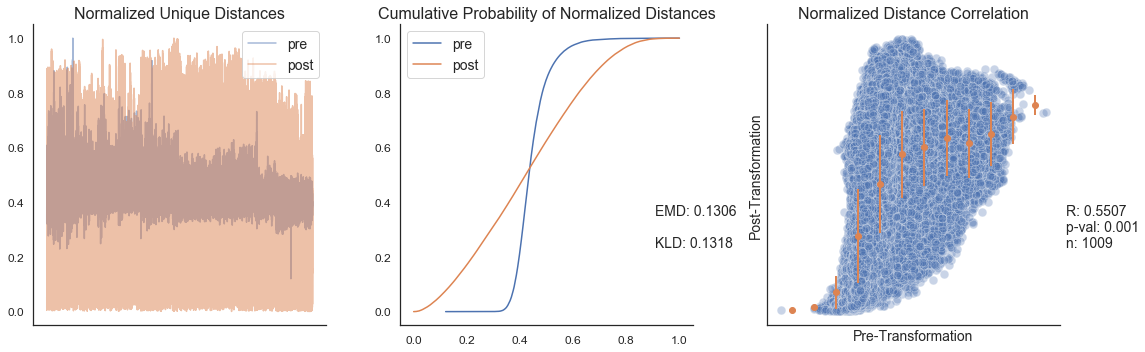

Knn Preservation: 96.5519

CPU times: user 28.7 s, sys: 4.71 s, total: 33.4 s
Wall time: 32.7 s


In [91]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_tSNE.knn_graph(k))))

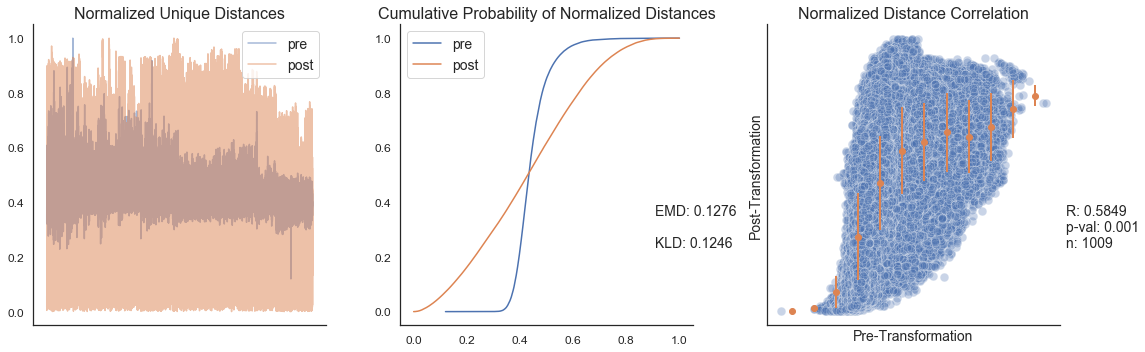

Knn Preservation: 96.5631

CPU times: user 28.2 s, sys: 3.1 s, total: 31.3 s
Wall time: 30.7 s


In [92]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_FItSNE.knn_graph(k))))

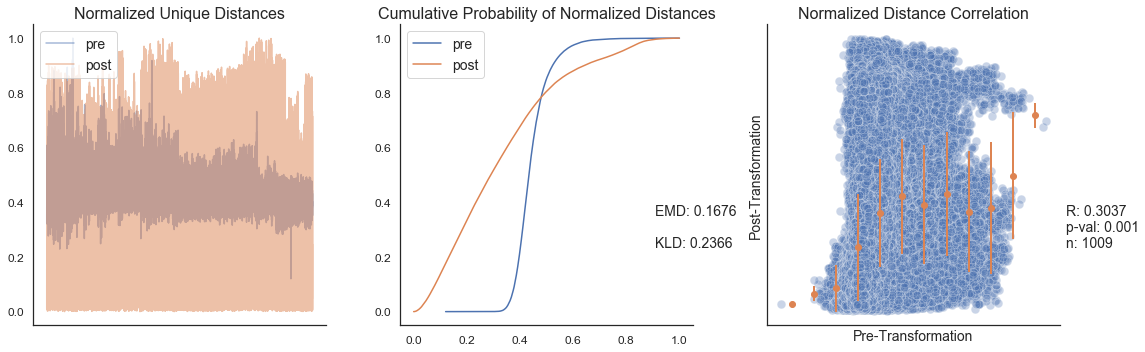

Knn Preservation: 95.2338

CPU times: user 28.8 s, sys: 2.77 s, total: 31.6 s
Wall time: 31 s


In [93]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_UMAP.knn_graph(k))))

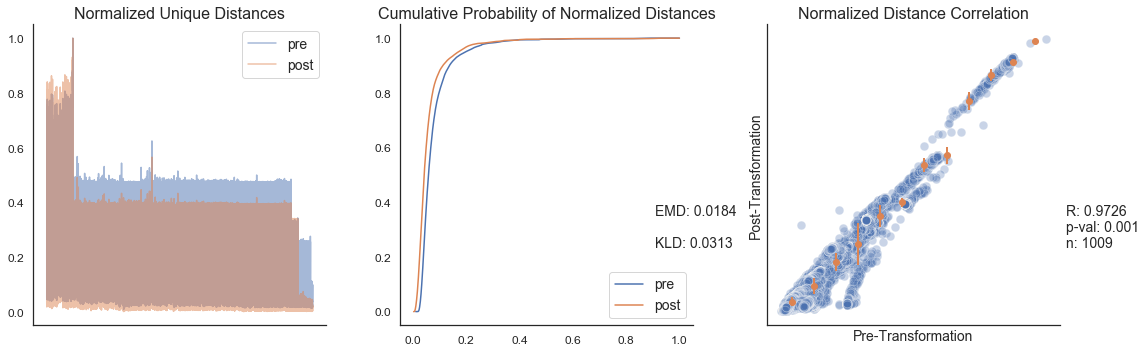

Knn Preservation: 96.8293

CPU times: user 29 s, sys: 5.06 s, total: 34.1 s
Wall time: 33.4 s


In [94]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0_DCA.knn_graph(k))))

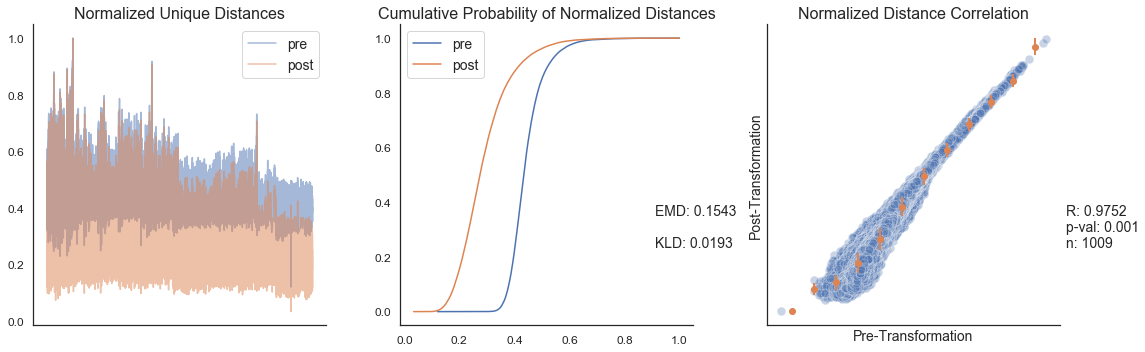

Knn Preservation: 98.7137

CPU times: user 27.3 s, sys: 4.72 s, total: 32 s
Wall time: 31.3 s


In [95]:
%%time
# look at 33-component PCA vs 500-feature dataset to compare to DCA
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA33.knn_graph(k))))